In [1]:
import torch
import torch.nn as nn
import torchvision
import os
import random
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from torch import cat
from torch import manual_seed
from torch.utils.data import DataLoader, Dataset
from torch import load
from torch import utils
from torch import optim
from torch import no_grad, max, mean
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import Counter
from torchmetrics import AUROC

In [2]:
transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.ColorJitter(hue=.1, saturation=.1, brightness = .1),
    torchvision.transforms.RandomHorizontalFlip(p = 1.),
    torchvision.transforms.RandomVerticalFlip(p = 1.),
    torchvision.transforms.RandomRotation(degrees = (0, 180))
    ])

In [3]:
train_data = ImageFolder(root = '/mnt/d/Lung_progression/data_10x/train',
                                              transform = transforms )
test_data = ImageFolder(root = '/mnt/d/Lung_progression/data_10x/test',
                                             transform = transforms)

In [4]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

In [5]:
train_dataset, val_dataset = utils.data.random_split(train_data,
                                                [train_size, val_size])


In [6]:
train_dataset.dataset.class_to_idx
print(dict(Counter(train_dataset.dataset.targets)))
print(dict(Counter(test_data.targets)))

{0: 6377, 1: 2423}
{0: 1530, 1: 800}


In [7]:
batch_size = 32


In [8]:
train_loader = utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
val_loader = utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle = True)
test_loader = utils.data.DataLoader(test_data, batch_size= batch_size)

In [9]:
loss = nn.CrossEntropyLoss()

In [10]:
def train(num_epochs):
    
    best_accuracy = 0.0
    
    print("Starting training...")
    
    for epoch in range(1, num_epochs + 1):
        running_train_loss = 0.0
        running_accuracy = 0.0
        running_val_loss = 0.0
        total = 0.0
        
        train_auroc = AUROC(pos_label = 1, num_classes = 2)
        val_auroc = AUROC(pos_label = 1, num_classes = 2)
        
        for data in train_loader:
            inputs, outputs = data
            inputs = inputs.to(device = 'cuda')
            outputs = outputs.to(device = 'cuda')
            optimizer.zero_grad()             
            predicted_outputs = model(inputs)   
            train_loss = loss(predicted_outputs, outputs)   
            train_loss.backward()   
            optimizer.step()        
            running_train_loss +=train_loss.item()
            train_auroc_batch = train_auroc(predicted_outputs, outputs)
            
        
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_loader) 
        avg_train_auroc = train_auroc.compute()
        
        # Validation Loop 
        with no_grad(): 
            model.eval()
            for data in val_loader:
                inputs, outputs = data
                inputs = inputs.to(device = 'cuda')
                outputs = outputs.to(device = 'cuda')
                predicted_outputs = model(inputs)
                val_loss = loss(predicted_outputs, outputs)
                
                _, predicted = max(predicted_outputs, 1)
                running_val_loss += val_loss.item()
                total += outputs.size(0)
                running_accuracy += (predicted == outputs).sum().item()
                val_auroc_batch = val_auroc(predicted_outputs, outputs)
         
                
        # Calculate validation loss value 
        val_loss_value = running_val_loss/len(val_loader) 
        avg_val_auroc = val_auroc.compute()        
        
        # Calculate accuracy as the number of correct pred
        accuracy = (100 * running_accuracy / total)     
        
        print('EPOCH', epoch,
              'Training Loss: %.4f' %train_loss_value, 
              'Train AUROC: %.4f' %avg_train_auroc,
              'Validation Loss: %.4f' %val_loss_value,
              'Validation AUROC: %.4f' %avg_val_auroc,
              'Accuracy %d %%' % (accuracy))
        train_auroc.reset()
        val_auroc.reset()
        

In [11]:
def test(model):
    test_auroc = AUROC(pos_label = 1, num_classes = 2)
    with no_grad():
        model.cuda()
        model.eval()
        for data in test_loader:
            inputs, outputs = data
            inputs = inputs.to(device = 'cuda')
            outputs = outputs.to(device = 'cuda')
            predicted_outputs = model(inputs)
            test_auroc_batch = test_auroc(predicted_outputs, outputs)
    
    avg_test_auroc = test_auroc.compute()
    return avg_test_auroc

In [12]:
randomlist = []
for i in range(0,1):
    n = random.randint(1,10000)
    randomlist.append(n)
print(randomlist)

results = []

for j in randomlist:
    
    manual_seed(j)
  
    model = models.resnet18(pretrained = True)
    
    

    model.fc = nn.Sequential(
               nn.Dropout(p = 0.7),
               nn.Linear(in_features=512, out_features = 2),
               )

    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.00001)
    model.cuda()
    train(5)
    
    optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.00001)
    model.cuda()
    train(5)
    
    results.append(test(model))
    
       
print(results)
    

[5188]
Starting training...


/home/alon/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/alon/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Argument `pos_label` should be `None` when running multiclass precision recall curve. Got 1
  warnings.warn(*args, **kwargs)


EPOCH 1 Training Loss: 0.6587 Train AUROC: 0.5592 Validation Loss: 0.5193 Validation AUROC: 0.7276 Accuracy 74 %
EPOCH 2 Training Loss: 0.5347 Train AUROC: 0.6781 Validation Loss: 0.5593 Validation AUROC: 0.7074 Accuracy 71 %
EPOCH 3 Training Loss: 0.5239 Train AUROC: 0.7088 Validation Loss: 0.6264 Validation AUROC: 0.6884 Accuracy 73 %
EPOCH 4 Training Loss: 0.5137 Train AUROC: 0.7226 Validation Loss: 0.4934 Validation AUROC: 0.7733 Accuracy 76 %
EPOCH 5 Training Loss: 0.4905 Train AUROC: 0.7563 Validation Loss: 0.4996 Validation AUROC: 0.7718 Accuracy 76 %
Starting training...
EPOCH 1 Training Loss: 0.4462 Train AUROC: 0.8050 Validation Loss: 0.4775 Validation AUROC: 0.7998 Accuracy 77 %
EPOCH 2 Training Loss: 0.4334 Train AUROC: 0.8174 Validation Loss: 0.4525 Validation AUROC: 0.8096 Accuracy 79 %
EPOCH 3 Training Loss: 0.4250 Train AUROC: 0.8238 Validation Loss: 0.4607 Validation AUROC: 0.7998 Accuracy 79 %
EPOCH 4 Training Loss: 0.4203 Train AUROC: 0.8294 Validation Loss: 0.4409 V

/home/alon/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/alon/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


EPOCH 5 Training Loss: 0.4143 Train AUROC: 0.8343 Validation Loss: 0.4448 Validation AUROC: 0.8160 Accuracy 80 %
[tensor(0.7873, device='cuda:0')]


In [13]:
test(model)

tensor(0.7783, device='cuda:0')

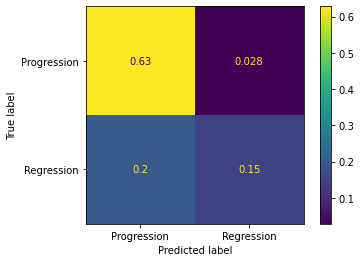

In [14]:
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
problist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        #inputs = inputs.to(device)
        #classes = classes.to(device)
        model.to('cpu')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = outputs
        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        problist = torch.cat([problist, probs.cpu()])

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
cm = conf_mat / np.sum(conf_mat)

isp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                         display_labels=['Progression','Regression'])
isp.plot()



In [15]:
problist = torch.nn.functional.softmax(problist)

/tmp/ipykernel_4341/2362989000.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  problist = torch.nn.functional.softmax(problist)


In [16]:
probz = problist[:,1].numpy()

In [17]:
cm

array([[0.62832618, 0.02832618],
       [0.19656652, 0.14678112]])

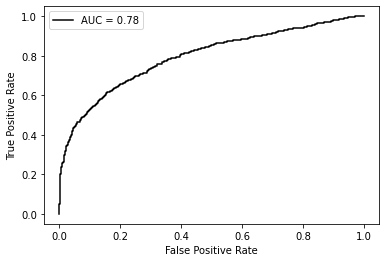

In [18]:
from matplotlib import pyplot as plt
nn_fpr, nn_tpr, threshold = roc_curve(lbllist , probz )
auc = roc_auc_score(lbllist, probz) 
plt.plot(nn_fpr, nn_tpr, 'black', label = 'AUC = 0.78')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
plt.legend()
plt.show()


In [19]:
auc

0.7950547385620915

In [20]:
params = list(model.parameters())
weight = np.squeeze(params[-2].data.numpy())

In [21]:
weight

array([[-0.03174774,  0.0237687 ,  0.01657442, ...,  0.02736389,
        -0.0020802 ,  0.03901567],
       [ 0.00259337,  0.04779056, -0.04612622, ...,  0.01358457,
        -0.04065438,  0.01700411]], dtype=float32)

In [22]:
weight.shape

(2, 512)

In [23]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
import ast
import json
from copy import deepcopy

import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models, transforms

In [25]:
transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

In [26]:
activation = {}

def get_activation(name):
    def hook(model, input, output):        
        activation[name] = output.detach()
    return hook

In [27]:
from PIL import Image

def get_data(input_image, model, transforms):
    # transform input image
    #image = Image.open(input_image).convert('RGB')
    input_data = transforms(input_image).unsqueeze(0)
    
    # imagenet labels to map from index to text label
    #labels = ast.literal_eval(open("imagenet1000_clsidx_to_labels.txt").read())
    
    # attach hook to layer 4
    model.layer4.register_forward_hook(get_activation("layer4"))
    
    model.eval();
    with torch.no_grad():
        preds = model(input_data)
        preds_softmax = torch.nn.functional.softmax(preds, dim=1)
        top_prob, top_pred = preds_softmax.max(dim=1)

        return top_pred, top_prob, activation

tensor([1])


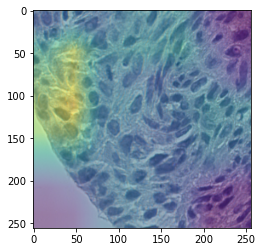

In [59]:
image = Image.open('/mnt/d/Lung_progression/data_10x/test/reg/S38_tile_76_level1_24240-27376-24752-27888.png'
).convert('RGB')

pred_class, pred_prob, activation = get_data(image, model, transforms)

print(pred_class)

fc_weights = model.fc[1].weight[pred_class, :].unsqueeze(2).unsqueeze(3)
fc_weights.shape

cam=torch.einsum("bchw,bchw->bhw", fc_weights, activation["layer4"])

# add dimension to make compatible with interpolation
cam = cam.unsqueeze(0)
cam.shape

final_cam = F.interpolate(cam, tuple(image.size[:2]), mode="bilinear")


plt.imshow(image)
plt.imshow(final_cam.squeeze().detach().numpy(), alpha=0.5)

plt.show()

In [29]:
image.size[:2]

(256, 256)

In [30]:
model.fc[1].weight

Parameter containing:
tensor([[-0.0317,  0.0238,  0.0166,  ...,  0.0274, -0.0021,  0.0390],
        [ 0.0026,  0.0478, -0.0461,  ...,  0.0136, -0.0407,  0.0170]],
       requires_grad=True)

In [31]:
img_tensor = preprocess(img)
img_variable = Variable(img_tensor)

NameError: name 'preprocess' is not defined

In [ ]:
img_variable.shape

In [ ]:
train_loader.dataset.dataset.